## Libraries, data import  and data preprocessing

In [311]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn import datasets, linear_model
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.model_selection import train_test_split

In [2]:
sales= pd.read_csv('Downloads\store_sales_per_category.csv', delimiter=';') #sprzedaz
distances=pd.read_csv('Downloads\store_distances_anonymized.csv')
education=pd.read_csv('Downloads\gdata_anonymized.csv')

In [3]:
sales.head()

,year,week,store_id,Vodka,Tequila,Whiskey,Other,Gin,Brandy,Rum
0,2012,1,0,1824.96,0.00,3645.81,5143.30,0.00,169.86,1507.50
1,2012,1,1,279.01,0.00,251.54,28.35,0.00,31.28,0.00
2,2012,1,2,441.60,0.00,1195.08,2434.44,231.12,162.96,395.76
3,2012,1,7,18432.50,406.68,24344.53,19546.09,3527.14,2113.41,7246.16
4,2012,1,8,3584.56,0.00,7175.44,5970.78,401.81,594.37,1043.21


In [4]:
#Combine week and year to date
sales['date'] = pd.to_datetime(sales['year'].astype(str) + ' ' + sales['week'].astype(str) + ' 1',format='%Y %U %w')
sales=sales.drop(['year','week'],axis=1)
sales.head()

,store_id,Vodka,Tequila,Whiskey,Other,Gin,Brandy,Rum,date
0,0,1824.96,0.00,3645.81,5143.30,0.00,169.86,1507.50,2012-01-02
1,1,279.01,0.00,251.54,28.35,0.00,31.28,0.00,2012-01-02
2,2,441.60,0.00,1195.08,2434.44,231.12,162.96,395.76,2012-01-02
3,7,18432.50,406.68,24344.53,19546.09,3527.14,2113.41,7246.16,2012-01-02
4,8,3584.56,0.00,7175.44,5970.78,401.81,594.37,1043.21,2012-01-02


In [274]:
#Sum alcohol sales as for us there is no difference in type of alcohol. We will look only at the sales done.
sales['Sales']=sales['Vodka']+sales['Tequila']+sales['Whiskey']+sales['Other']+sales['Gin']+sales['Brandy']+sales['Rum']
sales_total=sales[['date','store_id','Sales']]
sales_total['dateint']=sales_total['date'].dt.strftime("%Y%m%d").astype(int)
sales_total.head()

<ipython-input-274-b0515018aef6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_total['dateint']=sales_total['date'].dt.strftime("%Y%m%d").astype(int)


,date,store_id,Sales,dateint
0,2012-01-02,0,12291.43,20120102
1,2012-01-02,1,590.18,20120102
2,2012-01-02,2,4860.96,20120102
3,2012-01-02,7,75616.51,20120102
4,2012-01-02,8,18770.17,20120102


In [5]:
distances.head()

,store_id_1,store_id_2,distance
0,0,80,4.472470
1,0,87,1.621428
2,0,140,2.226306
3,0,174,2.904311
4,0,348,3.788029


In [6]:
education.head()

,university or college,foodstores or supermarkets or gorceries,restaurant,churches,gym,stadium,store_id
0,0,0,4,4,0,0,1856
1,0,0,20,15,3,0,1857
2,0,0,4,6,0,1,1858
3,0,0,0,4,0,0,1859
4,0,0,1,0,0,0,1860


## Fit a line into a data, count slope and search for potential credits 

In this part we are going to search for potential borrowers using basic Linear Regression concepts.
We are not going to predict future sales of each shop but we are going to fit a line to each shop sales and count slope and intercept for each of those shops.
Those with slope >=0 will be considered "promising" and we are going to evaluate their potential further.
Those with slope <0 will not be considered anymore as their sales are declining.

In [364]:
#Create dataframe holding data about slope, intercept, potential and final decision
summaryFrame=pd.DataFrame(sales_total['store_id'].unique(),columns=['store_id'])
summaryFrame['slope'],summaryFrame['intercept'],summaryFrame['potential'],summaryFrame['credit']=0,0,0,0
summaryFrame.head()

,store_id,slope,intercept,potential,credit
0,0,0,0,0,0
1,1,0,0,0,0
2,2,0,0,0,0
3,7,0,0,0,0
4,8,0,0,0,0


In [365]:
#Adding slope and intercept to summary datarame
def add_slope_intercept_to_summary(id,slope,intercept):
    summaryFrame.loc[summaryFrame['store_id'] == id, ['slope','intercept']] = [slope,intercept]

In [366]:
#Counting slope and intercept of a particular shop
import scipy.stats as sp
def slope_intercept_check(id,df,x='dateint',y='Sales'):
    Y=df[y]
    X=df[x]
    slope, intercept, r_value, p_value, std_err =sp.linregress(X,Y)
    add_slope_intercept_to_summary(id,slope,intercept)

In [367]:
#Create temporary dataframe for sales of each shop
def createDf(id,df,column='store_id'):
    tempDf=df.loc[df[column]==id]
    slope_intercept_check(id,tempDf)

In [368]:
#Main function to run previous three
id_list=sales_total['store_id'].unique().tolist()
for id in id_list:
    createDf(id,sales_total)

C:\Users\Piotrek\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\Piotrek\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\Piotrek\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [369]:
#If the slope is greater or equal to zero change potential column to 1
summaryFrame.loc[summaryFrame['slope'] >= 0, ['potential']] = 1
summaryFrame=summaryFrame.sort_values(by=['slope'], ascending=False)
summaryFrame.head()

,store_id,slope,intercept,potential,credit
41,57,23.358403,-4.699716e+08,1,0
358,551,19.448571,-3.913063e+08,1,0
185,286,7.782127,-1.565752e+08,1,0
218,343,6.256227,-1.258710e+08,1,0
1670,1823,4.734109,-9.548982e+07,1,0


In [370]:
summaryFrame.shape

(1711, 5)

In [371]:
#Create summary with potential borrowers
potentialFrame=summaryFrame.loc[summaryFrame['potential']==1]
potentialFrame=potentialFrame.sort_values(by=['slope'], ascending=False)
potentialFrame.shape

(464, 5)

In [372]:
#Create dataframe with sales of potential borrowers
neuralFrame=sales_total[sales_total['store_id'].isin(potentialFrame['store_id'])]
neuralFrame=neuralFrame.sort_values(by=['store_id'])
neuralFrame.head()

,date,store_id,Sales,dateint
2108,2012-01-23,5,1569.64,20120123
10582,2012-04-09,5,1442.95,20120409
11374,2012-04-16,5,1508.04,20120416
12161,2012-04-23,5,1566.93,20120423
13764,2012-05-07,5,835.05,20120507


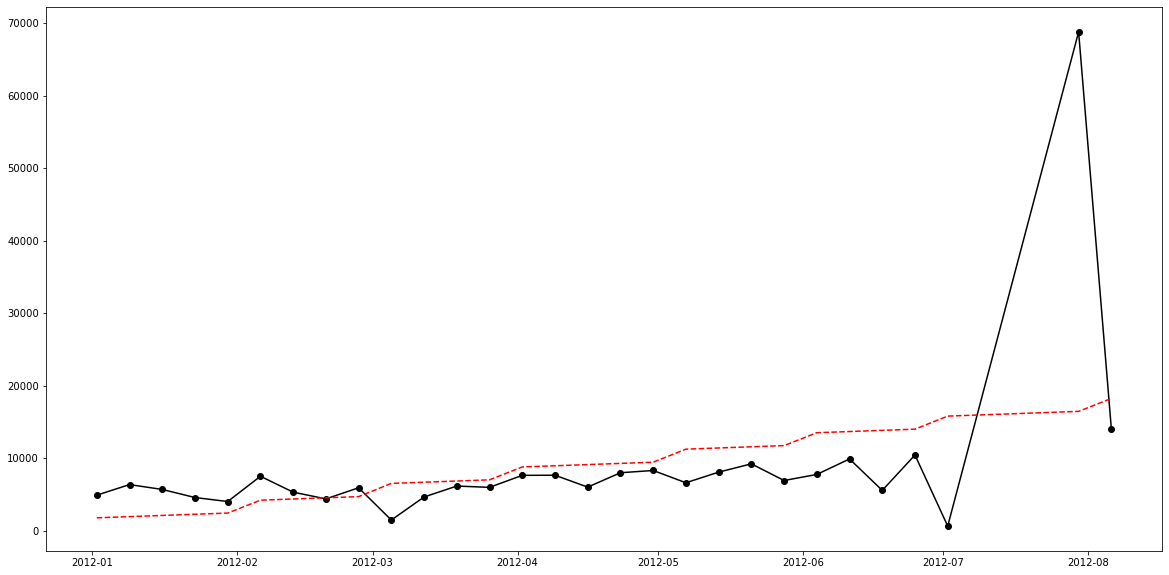

y=23.358403x+(-469971628.280886)


In [432]:
#Wykres slope dodatni
testdf=neuralFrame.loc[neuralFrame['store_id']==57]
testdf=testdf.sort_values(by=['date'])
plt.figure(figsize=(20, 10))
plt.plot(testdf['date'], testdf['Sales'],'-ok')
z = numpy.polyfit(testdf['dateint'], testdf['Sales'], 1)
p = numpy.poly1d(z)
plt.plot(testdf['date'],p(testdf['dateint']),"r--")
plt.show()
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

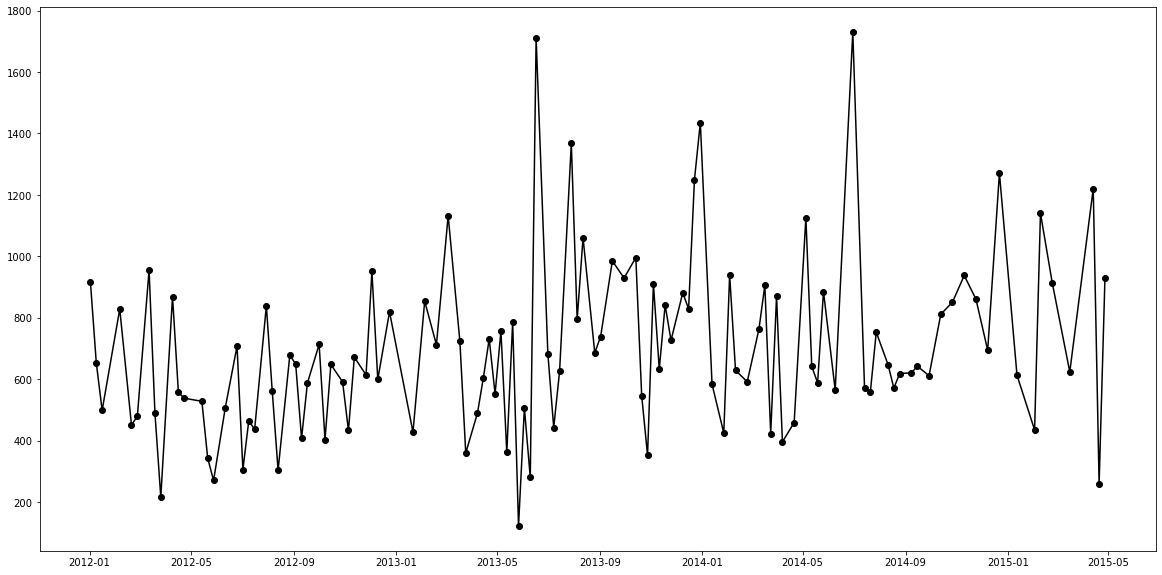

In [430]:
#Example of a shop that will be declined (shop with a slope<0 so it has potential=0)
testdfminus=sales_total.loc[sales_total['store_id']==454]
testdfminus=testdfminus.sort_values(by=['date'])
plt.figure(figsize=(20, 10))
plt.plot(testdfminus['date'], testdfminus['Sales'],'-ok')
plt.show()

# Predict next 10 sales with LSTM

In [375]:
neuralFrame.head()

,date,store_id,Sales,dateint
2108,2012-01-23,5,1569.64,20120123
10582,2012-04-09,5,1442.95,20120409
11374,2012-04-16,5,1508.04,20120416
12161,2012-04-23,5,1566.93,20120423
13764,2012-05-07,5,835.05,20120507


In [376]:
#Adding column that keeps slope of predicted next 10 sales weeks
summaryFrame['slopeLSTM']=0
summaryFrame.head()

,store_id,slope,intercept,potential,credit,slopeLSTM
41,57,23.358403,-4.699716e+08,1,0,0
358,551,19.448571,-3.913063e+08,1,0,0
185,286,7.782127,-1.565752e+08,1,0,0
218,343,6.256227,-1.258710e+08,1,0,0
1670,1823,4.734109,-9.548982e+07,1,0,0


In [377]:
#We have 1711 shops 
summaryFrame.shape

(1711, 6)

In [379]:
#We have 464 shops after primary evaluation
potentialFrame.shape

(464, 5)

In [380]:
#Applying slope of last 10 data points to a column
def summary_slope_credit(lst_output,id):
    X=np.arange(1,11)
    Y=[item for sublist in scaler.inverse_transform(lst_output) for item in sublist]
    slope, intercept, r_value, p_value, std_err =sp.linregress(X,Y)
    print("First loop is over: "),print(slope),print(id)
    summaryFrame.loc[summaryFrame['store_id'] == id, ['slopeLSTM']] = [slope]
    print(summaryFrame.loc[summaryFrame['store_id'] == id])

In [381]:
#Prediction of next 10 sales 
def predict_10_days(x_input,temp_input,model,id):
    lst_output=[]
    n_steps=5
    i=0
    while(i<10):
        if(len(temp_input)>5):
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1 
    summary_slope_credit(lst_output,id)

In [382]:
#This function trains model for each shop
def training_prediction(model,X_train, y_train,X_test, ytest,id):
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    error=math.sqrt(mean_squared_error(y_train,train_predict))
    mean_squared_error_list.append(error)
    x_input=test_data[96:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    predict_10_days(x_input,temp_input,model,id)

In [383]:
#Creating our model and fitting data into it
def model_creation(X_train, y_train,X_test, ytest,id):
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(5,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=300,batch_size=64,verbose=0)
    training_prediction(model,X_train, y_train,X_test, ytest,id)

In [384]:
# Making dataset for further predictions
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [385]:
#Splitting data into X and Y "columns"
def x_y_train_test(train_data,test_data,id):
    time_step = 5
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, ytest = create_dataset(test_data, time_step)
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    model_creation(X_train, y_train,X_test, ytest,id)

In [386]:
#Creation of temporary dataframe based on current store_id, scaling and splitting data into training and testing data
def createDf(id):
    df1=neuralFrame.loc[neuralFrame['store_id']==id]
    df1=przyklad.sort_values(by=['date'])
    df1=przyklad[['date','Sales']]
    df1=przyklad.reset_index()['Sales']
    np.random.seed(7)
    scaler=MinMaxScaler(feature_range=(0,1))
    df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
    training_size=int(len(df1)*0.65)
    test_size=len(df1)-training_size
    train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
    x_y_train_test(train_data,test_data,id)

In [387]:
#Searching for unique id's in neuralFrame, mean_squared_error_list will keep MSE of all LSTM models for further evaluation
neural_list=neuralFrame['store_id'].unique().tolist()
mean_squared_error_list=[]
for store_id in neural_list:
    createDf(store_id)

First loop is over: 
16.477263563341257
5
     store_id     slope     intercept  potential  credit  slopeLSTM
615         5  0.551836 -1.110177e+07          1       0  16.477264
First loop is over: 
17.225511414888217
10
   store_id     slope      intercept  potential  credit  slopeLSTM
6        10  0.009996 -198091.054495          1       0  17.225511
First loop is over: 
15.328465007727786
16
     store_id     slope      intercept  potential  credit  slopeLSTM
620        16  0.011721 -227916.071646          1       0  15.328465
First loop is over: 
16.621342891255097
25
    store_id    slope    intercept  potential  credit  slopeLSTM
13        25  0.00365 -72050.91463          1       0  16.621343
First loop is over: 
15.300238337529418
31
     store_id     slope     intercept  potential  credit  slopeLSTM
622        31  0.008962 -179597.22207          1       0  15.300238
First loop is over: 
16.956596795644707
32
     store_id     slope      intercept  potential  credit  slopeLSTM


First loop is over: 
16.131615812012633
303
     store_id     slope     intercept  potential  credit  slopeLSTM
868       303  0.004149 -82386.867056          1       0  16.131616
First loop is over: 
18.710079949667048
331
     store_id     slope     intercept  potential  credit  slopeLSTM
210       331  0.004572 -87105.068897          1       0   18.71008
First loop is over: 
16.658348601525468
333
     store_id     slope      intercept  potential  credit  slopeLSTM
212       333  0.008441 -168569.795825          1       0  16.658349
First loop is over: 
18.872949976006222
336
     store_id     slope      intercept  potential  credit  slopeLSTM
679       336  0.027523 -551823.236236          1       0   18.87295
First loop is over: 
16.26228224353085
339
     store_id     slope     intercept  potential  credit  slopeLSTM
216       339  0.002075 -40176.583484          1       0  16.262282
First loop is over: 
16.45030460547045
343
     store_id     slope     intercept  potential  cred

First loop is over: 
14.907522259099007
477
     store_id   slope      intercept  potential  credit  slopeLSTM
307       477  0.0063 -124116.879737          1       0  14.907522
First loop is over: 
13.701112019192985
479
     store_id     slope      intercept  potential  credit  slopeLSTM
309       479  0.012156 -243579.976963          1       0  13.701112
First loop is over: 
15.748000629324792
480
     store_id     slope      intercept  potential  credit  slopeLSTM
310       480  0.013884 -277014.833169          1       0  15.748001
First loop is over: 
16.439246375354834
481
     store_id     slope      intercept  potential  credit  slopeLSTM
311       481  0.037896 -760459.613715          1       0  16.439246
First loop is over: 
17.964265365448856
482
     store_id     slope      intercept  potential  credit  slopeLSTM
312       482  0.008653 -173419.867607          1       0  17.964265
First loop is over: 
15.293134437239521
483
     store_id     slope     intercept  potential  

First loop is over: 
15.655624927057454
572
     store_id     slope    intercept  potential  credit  slopeLSTM
738       572  0.003347 -65676.95978          1       0  15.655625
First loop is over: 
16.909335691658825
573
     store_id     slope     intercept  potential  credit  slopeLSTM
739       573  1.527059 -3.072322e+07          1       0  16.909336
First loop is over: 
16.260909008694412
577
     store_id     slope     intercept  potential  credit  slopeLSTM
374       577  0.001067 -20022.424786          1       0  16.260909
First loop is over: 
18.228042793212506
580
     store_id    slope    intercept  potential  credit  slopeLSTM
376       580  0.00042 -6470.457664          1       0  18.228043
First loop is over: 
19.410698690483063
582
     store_id     slope     intercept  potential  credit  slopeLSTM
378       582  0.001583 -30566.691058          1       0  19.410699
First loop is over: 
13.16546606304789
591
     store_id     slope      intercept  potential  credit  slop

First loop is over: 
16.38643296058881
709
     store_id     slope    intercept  potential  credit  slopeLSTM
453       709  0.000581 -10601.53818          1       0  16.386433
First loop is over: 
15.987564126669437
713
     store_id     slope     intercept  potential  credit  slopeLSTM
879       713  0.002963 -58876.952035          1       0  15.987564
First loop is over: 
16.952119179937863
715
     store_id     slope     intercept  potential  credit  slopeLSTM
455       715  0.002679 -52890.085183          1       0  16.952119
First loop is over: 
16.980934516706235
716
     store_id     slope      intercept  potential  credit  slopeLSTM
933       716  0.007602 -152134.479722          1       0  16.980935
First loop is over: 
16.031430482607885
718
     store_id     slope      intercept  potential  credit  slopeLSTM
457       718  0.030616 -614221.868596          1       0   16.03143
First loop is over: 
14.658869644150583
720
     store_id     slope     intercept  potential  credi

First loop is over: 
15.878869933274649
819
     store_id     slope    intercept  potential  credit  slopeLSTM
891       819  0.000488 -8964.823162          1       0   15.87887
First loop is over: 
14.084698597829444
820
     store_id     slope     intercept  potential  credit  slopeLSTM
509       820  0.037114 -745727.39062          1       0  14.084699
First loop is over: 
14.949775010021334
822
     store_id    slope     intercept  potential  credit  slopeLSTM
511       822  0.00311 -61450.667989          1       0  14.949775
First loop is over: 
14.513643750479718
829
     store_id     slope      intercept  potential  credit  slopeLSTM
809       829  0.026002 -522508.322322          1       0  14.513644
First loop is over: 
15.871606186815278
831
     store_id    slope     intercept  potential  credit  slopeLSTM
516       831  0.00229 -44783.616632          1       0  15.871606
First loop is over: 
18.16234024867234
839
     store_id     slope     intercept  potential  credit  slo

First loop is over: 
16.323107917495737
935
     store_id     slope      intercept  potential  credit  slopeLSTM
551       935  0.010284 -206138.027302          1       0  16.323108
First loop is over: 
18.08842954323688
936
     store_id     slope     intercept  potential  credit  slopeLSTM
841       936  0.006507 -129849.04149          1       0   18.08843
First loop is over: 
17.320115589091262
938
     store_id     slope     intercept  potential  credit  slopeLSTM
552       938  0.004683 -93289.094297          1       0  17.320116
First loop is over: 
16.406784382590736
939
     store_id    slope     intercept  potential  credit  slopeLSTM
928       939  0.00398 -79250.550402          1       0  16.406784
First loop is over: 
16.87424092431682
940
     store_id     slope     intercept  potential  credit  slopeLSTM
843       940  0.005046 -100862.89642          1       0  16.874241
First loop is over: 
16.23150933201926
941
     store_id     slope      intercept  potential  credit  

First loop is over: 
14.479449409830742
1034
     store_id     slope      intercept  potential  credit  slopeLSTM
585      1034  0.018981 -379764.350265          1       0  14.479449
First loop is over: 
14.067260222034907
1043
     store_id     slope      intercept  potential  credit  slopeLSTM
969      1043  0.005361 -106777.885304          1       0   14.06726
First loop is over: 
15.255969121169858
1044
     store_id     slope     intercept  potential  credit  slopeLSTM
970      1044  0.001871 -36659.970921          1       0  15.255969
First loop is over: 
14.532983694765587
1048
     store_id     slope     intercept  potential  credit  slopeLSTM
590      1048  0.004361 -86505.806316          1       0  14.532984
First loop is over: 
16.565743586106727
1050
     store_id     slope     intercept  potential  credit  slopeLSTM
972      1050  0.001339 -26102.289419          1       0  16.565744
First loop is over: 
17.196587190428456
1052
     store_id    slope     intercept  potentia

First loop is over: 
14.396453192344213
1208
      store_id     slope     intercept  potential  credit  slopeLSTM
1102      1208  0.001305 -25212.360943          1       0  14.396453
First loop is over: 
15.624241475289509
1209
      store_id     slope      intercept  potential  credit  slopeLSTM
1110      1209  0.008219 -163990.633456          1       0  15.624241
First loop is over: 
18.02258902621358
1218
      store_id     slope      intercept  potential  credit  slopeLSTM
1103      1218  0.010109 -202931.370716          1       0  18.022589
First loop is over: 
15.337287554802316
1219
     store_id     slope      intercept  potential  credit  slopeLSTM
609      1219  0.027175 -546094.431481          1       0  15.337288
First loop is over: 
16.585354908325446
1222
     store_id     slope     intercept  potential  credit  slopeLSTM
611      1222  0.004611 -90823.215311          1       0  16.585355
First loop is over: 
16.893788308067744
1229
      store_id     slope     intercept 

First loop is over: 
16.854810120103025
1448
      store_id    slope     intercept  potential  credit  slopeLSTM
1322      1448  0.05958 -1.197565e+06          1       0   16.85481
First loop is over: 
19.021928528922064
1516
      store_id     slope      intercept  potential  credit  slopeLSTM
1381      1516  0.011679 -234664.773273          1       0  19.021929
First loop is over: 
17.13519352172901
1527
      store_id     slope     intercept  potential  credit  slopeLSTM
1394      1527  0.003103 -61516.333889          1       0  17.135194
First loop is over: 
14.738908827686846
1530
      store_id     slope     intercept  potential  credit  slopeLSTM
1420      1530  0.001153 -22396.977261          1       0  14.738909
First loop is over: 
16.666703628600533
1544
      store_id     slope     intercept  potential  credit  slopeLSTM
1404      1544  0.044381 -891990.17684          1       0  16.666704
First loop is over: 
16.590414219867093
1546
      store_id     slope     intercept  p

First loop is over: 
17.71938992750373
1820
      store_id     slope     intercept  potential  credit  slopeLSTM
1682      1820  0.860667 -1.735945e+07          1       0   17.71939
First loop is over: 
18.92556003760027
1823
      store_id     slope     intercept  potential  credit  slopeLSTM
1670      1823  4.734109 -9.548982e+07          1       0   18.92556
First loop is over: 
16.27368901040698
1825
      store_id     slope     intercept  potential  credit  slopeLSTM
1675      1825  0.888015 -1.791058e+07          1       0  16.273689
First loop is over: 
16.132499893533456
1836
      store_id     slope     intercept  potential  credit  slopeLSTM
1681      1836  0.610412 -1.231092e+07          1       0    16.1325
First loop is over: 
17.611787255094796
1858
     store_id     slope      intercept  potential  credit  slopeLSTM
973      1858  0.005556 -111173.067785          1       0  17.611787
First loop is over: 
16.442734867772362
1869
      store_id     slope      intercept  po

Example of prediction for training and testing dataset

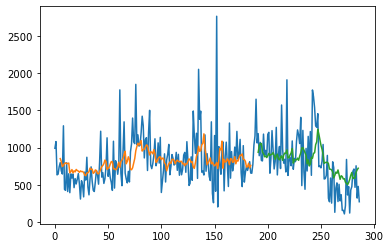

In [247]:
#Shift train predictions for plotting
look_back=5
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Prediction of sales for next 10 data points

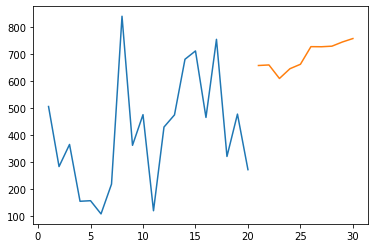

In [289]:
#Blue line represents last 20 data points and orange line represents LSTM based prediction for the next 10 data points
plt.plot(day_new,scaler.inverse_transform(df1[267:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [401]:
#If the slopeLSTM is greater or equal to zero change credit column to 1
summaryFrame.loc[(summaryFrame['slopeLSTM'] > 0) &(summaryFrame['potential']==1) , 'credit'] = 1
summaryFrame.head()

,store_id,slope,intercept,potential,credit,slopeLSTM
41,57,23.358403,-4.699716e+08,1,1,17.208184
358,551,19.448571,-3.913063e+08,1,1,16.941506
185,286,7.782127,-1.565752e+08,1,1,15.207625
218,343,6.256227,-1.258710e+08,1,1,16.450305
1670,1823,4.734109,-9.548982e+07,1,1,18.925560


In [402]:
summaryFrame.shape

(1711, 6)

In [403]:
summaryFrame.loc[summaryFrame['potential']==1].shape

(464, 6)

In [405]:
summaryFrame.loc[summaryFrame['slopeLSTM'] > 0].shape

(464, 6)

In [416]:
from statistics import mean
avg=mean(mean_squared_error_list)
print('Average mean squared error of all models is: '+str(avg))

Average mean squared error of all models is: 817.3300846125331


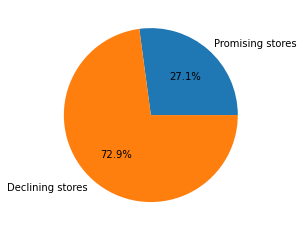

In [428]:
total=summaryFrame.shape[0]
credit=summaryFrame.loc[summaryFrame['slopeLSTM'] > 0].shape[0]
nocredit=total-credit
y = np.array([credit,nocredit])
labels=['Promising stores', 'Declining stores']
plt.pie(y, labels = labels, autopct='%1.1f%%')
plt.show() 

All of potential borrowers turned out to be real borrowers after LSTM prediction. It means that using LSTM in this case was not useful. In this case we will delete credit column and use potential column as our decision column.

# Classification

Previous steps were time and memory efficient, it is not effective to do this type of analysis every time new borrower will ask for a loan. 
So for future predictions I will try to change this unsupervised problem to supervised and I will do classification based on education and summary dataframe where our target value will be a potential column.

In [406]:
education.head()

,university or college,foodstores or supermarkets or gorceries,restaurant,churches,gym,stadium,store_id
0,0,0,4,4,0,0,1856
1,0,0,20,15,3,0,1857
2,0,0,4,6,0,1,1858
3,0,0,0,4,0,0,1859
4,0,0,1,0,0,0,1860


In [407]:
summaryFrame.head()

,store_id,slope,intercept,potential,credit,slopeLSTM
41,57,23.358403,-4.699716e+08,1,1,17.208184
358,551,19.448571,-3.913063e+08,1,1,16.941506
185,286,7.782127,-1.565752e+08,1,1,15.207625
218,343,6.256227,-1.258710e+08,1,1,16.450305
1670,1823,4.734109,-9.548982e+07,1,1,18.925560


In [408]:
klasyfikator=summaryFrame[['store_id','potential']]
klasyfikator.head()

,store_id,potential
41,57,1
358,551,1
185,286,1
218,343,1
1670,1823,1


In [413]:
#Merging summary and education dataframe for our classification
result = pd.merge(klasyfikator, education, how="inner", on=["store_id"])
result=result.sort_values(by=['store_id'])
result.head()

,store_id,potential,university or college,foodstores or supermarkets or gorceries,restaurant,churches,gym,stadium
1401,0,0,5,7,20,20,20,3
726,1,0,0,0,0,0,0,0
1457,2,0,2,8,20,20,16,4
1592,3,0,0,2,9,11,3,0
1028,4,0,0,0,1,6,0,0


In [417]:
#Splitting data into a training set and testing set
X=result[['university or college','foodstores or supermarkets or gorceries','restaurant','gym','stadium']]
y=result['potential'] 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

In [419]:
#Here we will choose which classificator gives highest accuracy score
classifiers=[]
model1 = svm.SVC()
classifiers.append(model1)
model2 = tree.DecisionTreeClassifier()
classifiers.append(model2)
model3 = RandomForestClassifier()
classifiers.append(model3)
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of %s is %s"%(clf, acc))

Accuracy of SVC() is 0.72568093385214
Accuracy of DecisionTreeClassifier() is 0.6673151750972762
Accuracy of RandomForestClassifier() is 0.6498054474708171


So in this case we will use support vector classifier

# Summary 

In this project we looked at each shop individually. Using Linear Regression and Deep Learning we estimated if the shop is on the rise or not. After unsupervised part of this project I decided to simplify this process by using classification on already predicted values.

What was accomplished:
-clear and multi-variant system for finding trusted borrowers
-in the classification part we can check how surroundings of each shop can influence it's sales

What can be done better:
-as it turned out using Deep Learning and Linear regression gave us the same results so next time it should be taken into consideration
-it would be very useful to have some type of data with previous loans, shops and if those were good decisions to have some sort of validation